# TP12: Réseaux récurrents

La semaine dernière, nous avons utilisé des réseaux à convolution, où les paramètres sont partagés suivant les dimensions (x, y) des images puisque c'est la même matrice de poids (le noyau de la convolution), qui est appliqué sur les morceaux d'images extraits en parcourant l'image. Cette fois ci, nous allons utiliser des réseaux récurrents. Ceux ci sont aussi une forme de partage de paramètres, puisque comme nous allons le voir on utilise les mêmes paramètres à chaque étape.

Les réseaux récurrents sont adaptés pour manipuler des données séquentielles, et de longueur variable. Le principe de base c'est qu'on a une cellule récurrente qui prend en entrée une étape de la séquence d'entrée, mais aussi la couche cachée du pas précédent de la séquence. Cette cellule retourne de nouvelles valeurs pour la couche cachée suivante, qui sera passée à la cellule suivante, et ainsi de suite.

Dans ce TP, nous allons implémenter un classifieur de texte. A partir d'un ensemble de noms de famille et leur origine géographique, on va entrainer un classifieur qui devinera l'origine pour un nom donné.

Ce TP est largement emprunté au site https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html , où vous trouverez également d'autres tutoriels très intéressants pour les plus motivés!

# TP12: Recurrent networks

Last week we used convolutional neural networks, where parameters are shared accross dimensions (x, y) since the same weight matrix (the kernel of the convolution) is applied to all image patches extracted from the image. This time, we are going to use recurrent networks. These also are a way of sharing parameters, since as we will see, we are going to use the same parameters accross steps.

Recurrent neural networks are suited to variable length, sequential data. The base building block is a recurrent cell that takes one step of the input sequence, and the hidden state from the previous cell. This cell computes values for the next hidden state, that will be passed to the next recurrent cell, and so on.

In this lab, we are going to implement a text classifier. Given a dataset of surnames and their geographical origin, we are going to train a classifier to tell the origin of a name.

This lab is largely inspired from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html , where you will also find other very interesting tutorials !

---


Tout d'abord, commençons par exécuter les 2 cellules suivantes, qui se chargent d'installer pytorch si besoin, puis de charger les données de texte dans un objet DataLoader. Il n'est pas nécessaire de comprendre en détail ce qui y est fait, on va expliquer ce qu'on a besoin dans les cellules suivantes.

First, let's start with the next 2 cells, which install pytorch if needed, and load the text data into a DataLoader object. It is not necessary to understand in detail what is done there, we will explain what is needed in the following cells.


In [0]:
!wget -c https://download.pytorch.org/tutorial/data.zip
  
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

--2018-11-23 16:12:16--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.80.66, 13.32.80.97, 13.32.80.22, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.80.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  14.4MB/s    in 0.2s    

2018-11-23 16:12:17 (14.4 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [0]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import os
from zipfile import ZipFile
import unicodedata
import string
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import time

class InternationalNames(Dataset):
  
    def __init__(self):

        self.all_letters = string.ascii_letters + " .,;'"
        def unicodeToAscii(s):
            return ''.join(
                c for c in unicodedata.normalize('NFD', s)
                if unicodedata.category(c) != 'Mn'
                and c in self.all_letters
            )
        self.n_letters = len(self.all_letters)

        self.names = []
        self.name_categories = {}
        self.categories = []
        with ZipFile('data.zip') as zipf:
            for f_name in zipf.namelist():
                if f_name[:11] == 'data/names/' and f_name[-4:] == '.txt':
                    category = os.path.splitext(os.path.basename(f_name))[0]
                    self.categories.append(category)
                    with zipf.open(f_name, 'r') as f:
                        self.name_categories[category] = \
                          [unicodeToAscii(n) for n in f.read().decode('utf8').strip().split('\n')]
        self.n_categories = len(self.name_categories)

        self.letters_to_index = {l: i for i, l in enumerate(self.all_letters)}
        self.categories_to_index = {c: i for i, c in enumerate(self.categories)}

    def __len__(self):
        return len(self.names)

    def random_item(self):
        category = random.choice(self.categories)
        name = random.choice(self.name_categories[category])

        category_tensor = torch.tensor([self.categories_to_index[category]], dtype=torch.long)
        name_tensor = torch.zeros(len(name), 1, self.n_letters)
        for li, letter in enumerate(name):
            name_tensor[li][0][self.letters_to_index[letter]] = 1

        return category, name, category_tensor, name_tensor

## Exploration des données

Ensuite, nous allons créer une instance de `InternationalNames()`, puis nous allons afficher quelques exemples tirés au hasard. Il s'agit d'un ensemble de donnée qui contient des noms et leur pays d'origine correspondant.

Comme vous pouvez le voir dans la cellule suivante, lorsqu'on appelle la méthode `random_item` on obtient 4 objets: la catégories et le nom sous forme de texte, puis de nouveau la catégorie et le nom, mais cette fois si sous un format qui sera plus adapté pour l'entrainement du réseau récurrent:

*   La catégorie est associée à une classe numérotée de 0 à n_categories
*   Le nom est converti en une séquence de one_hot où chaque lettre est associée à sa position dans l'alphabet (exemple A=0, B=1, ...)

## Data exploration

Then we will create an instance of `InternationalNames ()`, and then we will show some examples drawn at random. This is a data set that contains names and their corresponding country of origin.

As you can see in the next cell, when calling the `random_item` method we get 4 objects: the categories and the name as text, then the category and the name again, but this time if in a format which will be more adapted during training of the recurrent network:

* The category is associated with a class numbered from 0 to n_categories
* The name is converted into a sequence of one_hot where each letter is associated with its position in the alphabet (example A=0, B=1, ...)


In [0]:
names_dataset = InternationalNames()
for i in range(10):
    category, name, category_tensor, name_tensor = names_dataset.random_item()
    print(category, name)
print(category_tensor.size(), name_tensor.size())

Polish Slusarski
Italian Gronchi
Italian Borgnino
Italian Damiani
Russian Lebedenko
Irish Milligan
Dutch Snyder
French Deforest
Polish Slazak
Korean Koo
torch.Size([1]) torch.Size([3, 1, 57])


## Implémentation d'une étape du calcul récurrent

Maintenant, au travail, nous allons implémenter une étape du calcul effectué par le réseau récurrent.

Pour rappel, en entrée de notre réseau on a une séquence de lettres d'un nom, et en sortie on veut savoir de quelle origine est ce nom. Donc pour chaque étape du réseau récurrent on aura en entrée une seule lettre, et en sortie de la dernière étape on aura un classifieur.

**Exercice: Implémenter une étape du réseau récurrent. Aidez vous de la cellule du dessous pour exécuter `output, next_hidden = rnn(input, hidden)` et vérifier que les tenseurs ont bien les bonnes dimensions.**

## Implementing one step of the recurrent computation

Now, at work, we will implement a computation step performed by the recurrent network.

As a reminder, as input of our network we have a sequence of letters of a name, and as output we want to know from which origin this name is. So for each step of the recurrent network we will have a single letter as input, and as output of the last step we will have a classifier.

** Exercise: Implement a step in the recurrent network. Use the cell below to execute `output, next_hidden = rnn (input, hidden)` and check that the tensors have the right dimensions. **

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # define parameters
        # input to hidden
        self.i2h = nn.Linear(input_size, hidden_size)
        ...

    def forward(self, input, hidden):
        hidden = self.i2h(...)
        output = ...
        ...
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(names_dataset.n_letters, n_hidden, names_dataset.n_categories)

TypeError: ignored

In [0]:
input = torch.zeros(1, names_dataset.n_letters)
hidden = torch.zeros(1, n_hidden)
print(input.size(), hidden.size())

output, next_hidden = rnn(input, hidden)
print(output.size(), next_hidden.size())

torch.Size([1, 57]) torch.Size([1, 128])
torch.Size([1, 18]) torch.Size([1, 128])


## Implémentation du calcul pour toute la séquence

Maintenant qu'on est capable de faire le calcul pour une étape, on va faire une boucle pour appliquer toutes les étapes de notre réseau récurrent.

**Exercice: Implémenter une fonction qui calcule la (log) prédiction à partir d'une séquence de lettres**

## Implementation of the recurrent computations for the whole sequence

Now that we are able to do one step, we will loop to apply all the steps of our recurring network.

** Exercise: Implement a function that computes the (log) prediction from a sequence of letters **

In [0]:
def output_rnn(rnn, input_sequence):
    hidden = rnn.initHidden()
    ...
    return output

## Entrainement du modèle

Maintenant qu'on a tout le nécessaire, on peut entrainer notre réseau récurrent:

## Training of the model

Now that we have everything we need, we can train our recurrent network:

In [0]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    
    output = output_rnn(rnn, name_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()
  

n_iter = 100000
print_every = 5000
plot_every = 1000
train_losses = []
current_loss = 0

start = time.time()

for i in range(1, n_iter+1):
    category, name, category_tensor, name_tensor = names_dataset.random_item()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    if i % plot_every == 0:
        train_losses.append(current_loss / plot_every)
        current_loss = 0

    if i % print_every == 0:
        print('iter %.6d (%.3d s): %f' % (i, time.time() - start, train_losses[-1]))


iter 005000 (007 s): 2.595718
iter 010000 (014 s): 2.203702
iter 015000 (021 s): 2.002149
iter 020000 (028 s): 1.895325
iter 025000 (035 s): 1.742744
iter 030000 (043 s): 1.696652
iter 035000 (050 s): 1.567761
iter 040000 (057 s): 1.522879
iter 045000 (064 s): 1.463544
iter 050000 (071 s): 1.427921
iter 055000 (078 s): 1.480689
iter 060000 (085 s): 1.358303
iter 065000 (093 s): 1.369211
iter 070000 (100 s): 1.271788
iter 075000 (108 s): 1.259037
iter 080000 (115 s): 1.225326
iter 085000 (122 s): 1.194611
iter 090000 (130 s): 1.160542
iter 095000 (138 s): 1.195443
iter 100000 (145 s): 1.100869


Affichons la courbe d'entrainement:

Let us display the training curve:

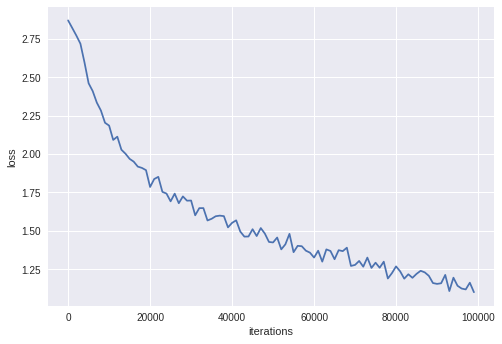

In [0]:
plt.plot(np.arange(len(train_losses)) * plot_every, train_losses)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

## Vérification du modèle: matrice de confusion

Maintenant que nous avons entrainé notre modèle, nous vérifions que les prédictions sur l'ensemble d'entrainement sont cohérentes. Exécutez la cellule ci-dessous pour afficher la matrice de confusion sur l'ensemble d'entrainement.

## Model verification: confusion matrix

Now that we have trained our model, we check that the predictions on the training set are consistent. Run the cell below to display the confusion matrix on the training set.

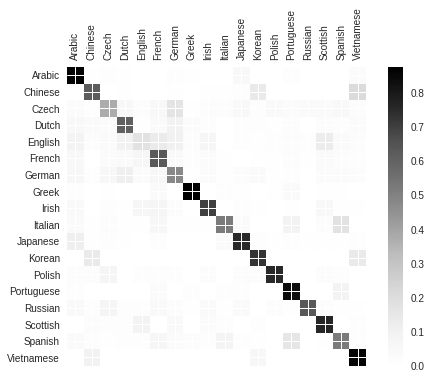

In [0]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(names_dataset.n_categories, names_dataset.n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, name, category_tensor, name_tensor = names_dataset.random_item()

    output = output_rnn(rnn, name_tensor)
    guess, guess_i = output.max(dim=1)
    category_i = names_dataset.categories_to_index[category]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(names_dataset.n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + names_dataset.categories, rotation=90)
ax.set_yticklabels([''] + names_dataset.categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Améliorations à apporter à notre classifieur

Maintenant que nous avons un classifieur qui fonctionne, on peut essayer d'autres réseaux récurrents.

**Exercice: Implémenter une cellule LSTM et une cellule GRU**

## Improving our classifier

Now that we have a classifier that works, we can try other recurrent networks.

** Exercise: Implement a LSTM cell and a GRU cell **